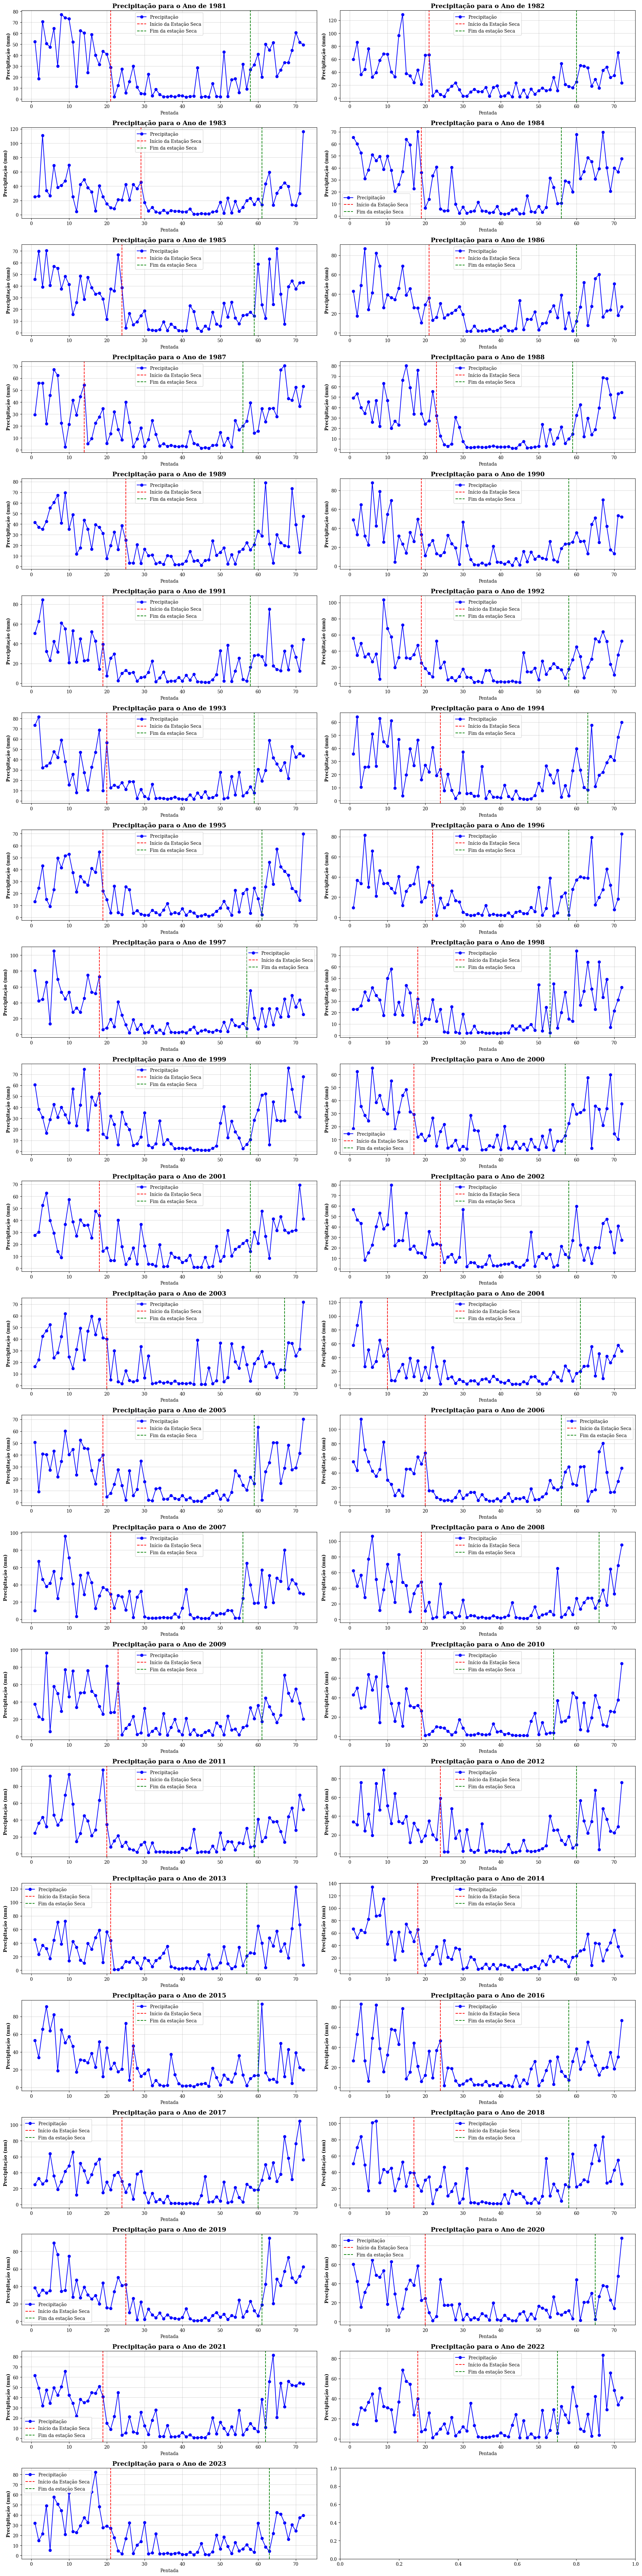

     Ano  Pentada_Início_Seca  Pentada_Fim_Seca  Duração_Seca
0   1981                   21                58            37
1   1982                   21                60            39
2   1983                   29                61            32
3   1984                   19                56            37
4   1985                   24                59            35
5   1986                   21                60            39
6   1987                   14                56            42
7   1988                   23                59            36
8   1989                   25                59            34
9   1990                   19                58            39
10  1991                   19                58            39
11  1992                   19                58            39
12  1993                   20                59            39
13  1994                   24                63            39
14  1995                   19                61            42
15  1996

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'

# Carregar dados do Excel
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDematada3_precipitacao.xlsx'
df = pd.read_excel(amazonia)

# Transformar o DataFrame para formato longo (long format)
df_long = pd.melt(df, id_vars=["Pentada"], var_name="Ano", value_name="Precipitação")

# Remover linhas onde "Ano" não seja um número (exemplo: "Média")
df_long = df_long[pd.to_numeric(df_long["Ano"], errors="coerce").notna()]

# Converter a coluna "Ano" para numérico
df_long["Ano"] = pd.to_numeric(df_long["Ano"])

# Converter a coluna "Pentada" para numérico, removendo a palavra "º"
df_long["Pentada"] = df_long["Pentada"].str.replace("º", "").astype(int)

# Filtrar os dados de 1981 a 2023
df_filtered = df_long[(df_long["Ano"] >= 1981) & (df_long["Ano"] <= 2023)]

# Lista para armazenar informações da estação seca e chuvosa
season_info = []

# Loop pelos anos para calcular A(day) e identificar início e fim das estações
for year in range(1981, 2024):  # Ajustado para incluir 2023
    year_data = df_filtered[df_filtered["Ano"] == year].copy()

    if year_data.empty:
        print(f"Ano {year} não possui dados suficientes para cálculo.")
        continue

    # Calcular a média anual diária
    R_mean = year_data["Precipitação"].mean()

    # Calcular A(day) acumulando precipitação e subtraindo a média acumulada
    year_data["A_day"] = year_data["Precipitação"].cumsum() - R_mean * year_data["Pentada"]

    # Identificar os pontos de mudança em A_day (início e fim da estação seca)
    try:
        min_index = year_data["A_day"].idxmin()  # Índice do mínimo de A(day)
        max_index = year_data["A_day"].idxmax()  # Índice do máximo de A(day)

        # Garantir que o início (mínimo) vem antes do fim (máximo)
        if min_index < max_index:
            inicio_seca = year_data.loc[min_index, "Pentada"]
            fim_seca = year_data.loc[max_index, "Pentada"]
        else:
            inicio_seca = year_data.loc[max_index, "Pentada"]
            fim_seca = year_data.loc[min_index, "Pentada"]
    except IndexError:
        print(f"Ano {year} não possui dados suficientes para identificar estação seca.")
        continue

    # Adicionar informações ao dataframe
    season_info.append({
        "Ano": year,
        "Pentada_Início_Seca": inicio_seca,
        "Pentada_Fim_Seca": fim_seca,
        "Duração_Seca": fim_seca - inicio_seca
    })

# Transformar as informações da estação em DataFrame
season_df = pd.DataFrame(season_info)

# Definir o caminho para salvar a imagem
output_path = "/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Resultados/AreaDesmatada3_analise.pdf"

# Plotar gráficos para visualizar precipitação e A(day)
fig, axes = plt.subplots(nrows=22, ncols=2, figsize=(20, 80))  # Relacao de tamanho, por quantidade de graficos plotados 
axes = axes.flatten()

for i, year in enumerate(range(1981, 2024)):  # Ajustado para 2023
    ax = axes[i]
    year_data = df_filtered[df_filtered["Ano"] == year]

    if year_data.empty:
        ax.set_title(f"Dados faltantes - {year}")
        continue

    # Plotar a precipitação
    ax.plot(year_data["Pentada"], year_data["Precipitação"], label="Precipitação", marker='o', color='blue')

    # Verificar se a coluna A_day existe antes de plotar
    if "A_day" in year_data.columns:
        # Plotar A(day)
        ax.plot(year_data["Pentada"], year_data["A_day"], label="A(day)", color="red", linestyle="--")
    else:
        ax.set_title(f"A coluna A_day não foi criada - {year}")
    
    # Marcar início e fim da estação seca
    dry_year = season_df[season_df["Ano"] == year]
    if not dry_year.empty:
        ax.axvline(x=dry_year["Pentada_Início_Seca"].values[0], color="red", linestyle="--", label="Início da Estação Seca")
        ax.axvline(x=dry_year["Pentada_Fim_Seca"].values[0], color="green", linestyle="--", label="Fim da estação Seca")

    # Configurações do gráfico
    ax.set_title(f"Precipitação para o Ano de {year}", fontweight='bold', fontsize=14)
    ax.set_xlabel("Pentada")
    ax.set_ylabel("Precipitação (mm)",  fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.5)

# Ajustar layout e salvar o gráfico em PDF
plt.tight_layout()
plt.savefig(output_path, format='pdf')  # Salva o gráfico como um PDF
plt.show()

# Exibir as informações da estação seca
print(season_df)


In [3]:
# Cálculos estatísticos sobre a duração da estação seca
def analyze_season_data(season_df):
    # Duração média da estação seca
    mean_duration = season_df["Duração_Seca"].mean()

    # Duração mínima e máxima
    min_duration = season_df["Duração_Seca"].min()
    max_duration = season_df["Duração_Seca"].max()

    # Ano com menor e maior duração
    min_year = season_df.loc[season_df["Duração_Seca"].idxmin(), "Ano"]
    max_year = season_df.loc[season_df["Duração_Seca"].idxmax(), "Ano"]

    # Aumento percentual da duração ao longo dos anos
    initial_duration = season_df.iloc[0]["Duração_Seca"]
    final_duration = season_df.iloc[-1]["Duração_Seca"]
    percentage_change = ((final_duration - initial_duration) / initial_duration) * 100

    # Exibir resultados no terminal
    print("\n--- Análise da Duração da Estação Seca ---")
    print(f"Duração Média (pentadas): {mean_duration:.2f}")
    print(f"Duração Mínima (pentadas): {min_duration} (Ano: {min_year})")
    print(f"Duração Máxima (pentadas): {max_duration} (Ano: {max_year})")
    print(f"Aumento Percentual ao longo dos anos: {percentage_change:.2f}%\n")

    # Retornar os resultados (caso precise usá-los depois)
    return {
        "Duração Média (pentadas)": mean_duration,
        "Duração Mínima (pentadas)": min_duration,
        "Ano Mínimo": min_year,
        "Duração Máxima (pentadas)": max_duration,
        "Ano Máximo": max_year,
        "Aumento Percentual (%)": percentage_change
    }

# Realizar análises e exibir no terminal
analysis_results = analyze_season_data(season_df)



--- Análise da Duração da Estação Seca ---
Duração Média (pentadas): 38.63
Duração Mínima (pentadas): 32 (Ano: 1983)
Duração Máxima (pentadas): 51 (Ano: 2004)
Aumento Percentual ao longo dos anos: 13.51%



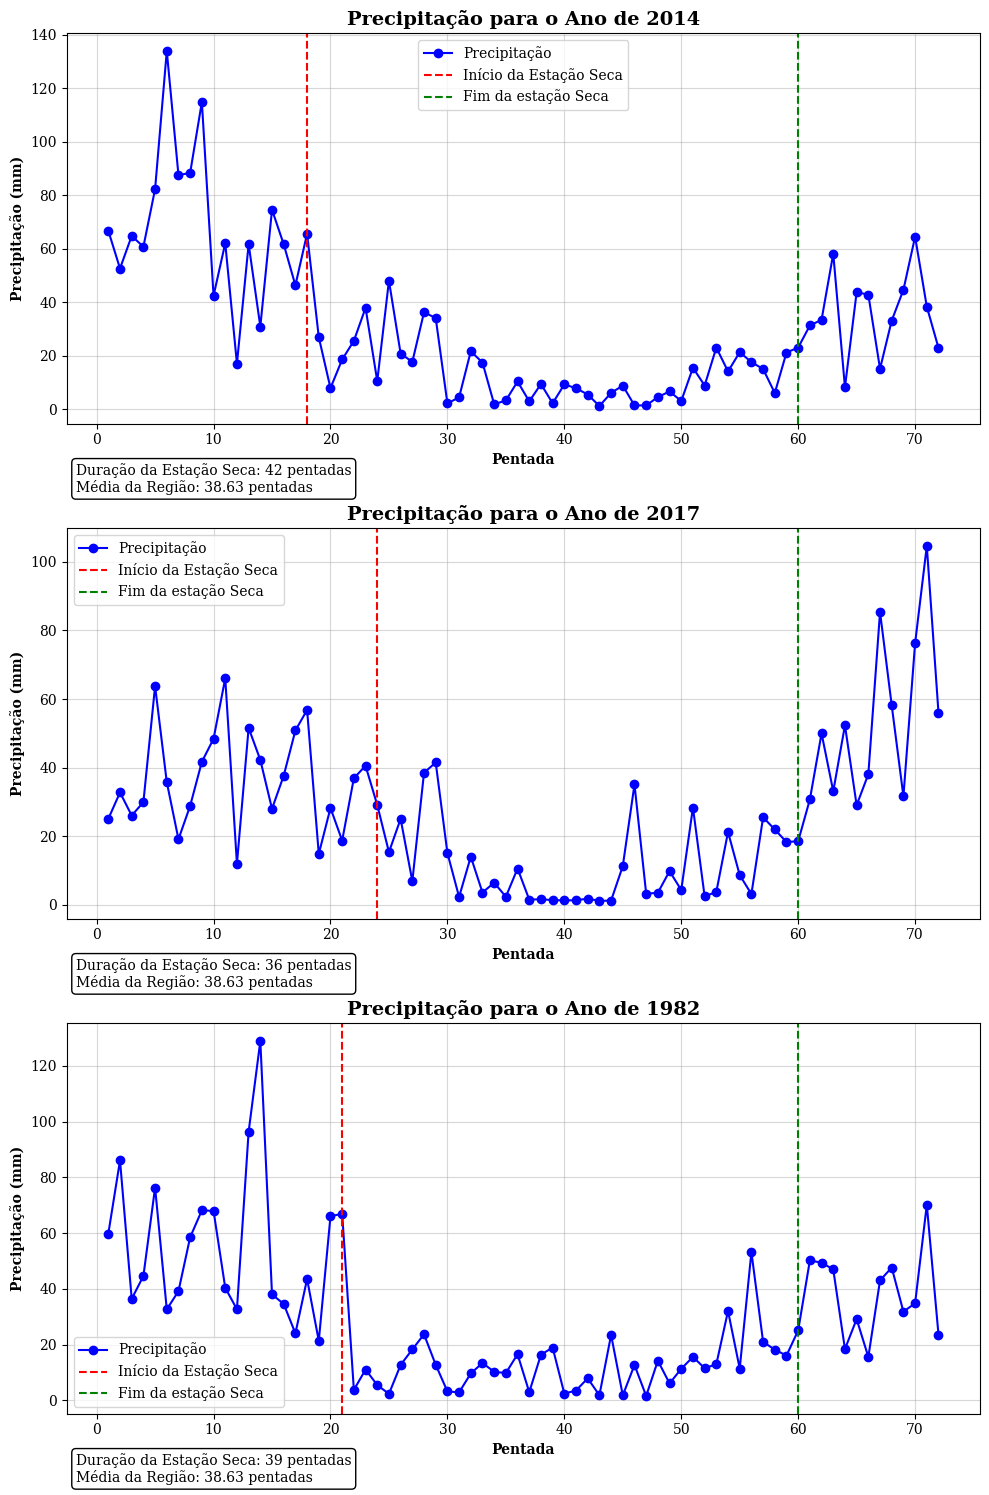

     Ano  Pentada_Início_Seca  Pentada_Fim_Seca  Duração_Seca
0   1981                   21                58            37
1   1982                   21                60            39
2   1983                   29                61            32
3   1984                   19                56            37
4   1985                   24                59            35
5   1986                   21                60            39
6   1987                   14                56            42
7   1988                   23                59            36
8   1989                   25                59            34
9   1990                   19                58            39
10  1991                   19                58            39
11  1992                   19                58            39
12  1993                   20                59            39
13  1994                   24                63            39
14  1995                   19                61            42
15  1996

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'

# Carregar dados do Excel
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDematada3_precipitacao.xlsx'
df = pd.read_excel(amazonia)

# Transformar o DataFrame para formato longo (long format)
df_long = pd.melt(df, id_vars=["Pentada"], var_name="Ano", value_name="Precipitação")

# Remover linhas onde "Ano" não seja um número (exemplo: "Média")
df_long = df_long[pd.to_numeric(df_long["Ano"], errors="coerce").notna()]

# Converter a coluna "Ano" para numérico
df_long["Ano"] = pd.to_numeric(df_long["Ano"])

# Converter a coluna "Pentada" para numérico, removendo a palavra "º"
df_long["Pentada"] = df_long["Pentada"].str.replace("º", "").astype(int)

# Filtrar os dados de 1981 a 2023
df_filtered = df_long[(df_long["Ano"] >= 1981) & (df_long["Ano"] <= 2023)]

# Lista para armazenar informações da estação seca e chuvosa
season_info = []

# Loop pelos anos para calcular A(day) e identificar início e fim das estações
for year in range(1981, 2024):  # Ajustado para incluir 2023
    year_data = df_filtered[df_filtered["Ano"] == year].copy()

    if year_data.empty:
        print(f"Ano {year} não possui dados suficientes para cálculo.")
        continue

    # Calcular a média anual diária
    R_mean = year_data["Precipitação"].mean()

    # Calcular A(day) acumulando precipitação e subtraindo a média acumulada
    year_data["A_day"] = year_data["Precipitação"].cumsum() - R_mean * year_data["Pentada"]

    # Identificar os pontos de mudança em A_day (início e fim da estação seca)
    try:
        min_index = year_data["A_day"].idxmin()  # Índice do mínimo de A(day)
        max_index = year_data["A_day"].idxmax()  # Índice do máximo de A(day)

        # Garantir que o início (mínimo) vem antes do fim (máximo)
        if min_index < max_index:
            inicio_seca = year_data.loc[min_index, "Pentada"]
            fim_seca = year_data.loc[max_index, "Pentada"]
        else:
            inicio_seca = year_data.loc[max_index, "Pentada"]
            fim_seca = year_data.loc[min_index, "Pentada"]
    except IndexError:
        print(f"Ano {year} não possui dados suficientes para identificar estação seca.")
        continue

    # Adicionar informações ao dataframe
    season_info.append({
        "Ano": year,
        "Pentada_Início_Seca": inicio_seca,
        "Pentada_Fim_Seca": fim_seca,
        "Duração_Seca": fim_seca - inicio_seca
    })

# Transformar as informações da estação em DataFrame
season_df = pd.DataFrame(season_info)

# Cálculo da duração média da estação seca da região
duracao_media_seca = season_df["Duração_Seca"].mean()

# Filtrar apenas os anos desejados (2014, 2017, 1982)
anos_desejados = [2014, 2017, 1982]
df_filtered_selected = df_filtered[df_filtered["Ano"].isin(anos_desejados)]

# Plotar gráficos apenas para os anos selecionados
fig, axes = plt.subplots(nrows=len(anos_desejados), ncols=1, figsize=(10, 15))
axes = axes.flatten()

for i, year in enumerate(anos_desejados):
    ax = axes[i]
    year_data = df_filtered[df_filtered["Ano"] == year]

    if year_data.empty:
        ax.set_title(f"Dados faltantes - {year}")
        continue

    # Plotar a precipitação
    ax.plot(year_data["Pentada"], year_data["Precipitação"], label="Precipitação", marker='o', color='blue')

    # Verificar se a coluna A_day existe antes de plotar
    if "A_day" in year_data.columns:
        # Plotar A(day)
        ax.plot(year_data["Pentada"], year_data["A_day"], label="A(day)", color="red", linestyle="--")
    else:
        ax.set_title(f"A coluna A_day não foi criada - {year}")
    
    # Marcar início e fim da estação seca
    dry_year = season_df[season_df["Ano"] == year]
    if not dry_year.empty:
        ax.axvline(x=dry_year["Pentada_Início_Seca"].values[0], color="red", linestyle="--", label="Início da Estação Seca")
        ax.axvline(x=dry_year["Pentada_Fim_Seca"].values[0], color="green", linestyle="--", label="Fim da estação Seca")

        # Adicionar legenda com duração da estação seca
        ax.text(
            0.01, -0.1,
            f"Duração da Estação Seca: {dry_year['Duração_Seca'].values[0]} pentadas\nMédia da Região: {duracao_media_seca:.2f} pentadas",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
        )

    # Configurações do gráfico
    ax.set_title(f"Precipitação para o Ano de {year}", fontweight='bold', fontsize=14)
    ax.set_xlabel("Pentada", fontweight='bold')
    ax.set_ylabel("Precipitação (mm)", fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.5)

# Ajustar layout e exibir os gráficos
plt.tight_layout()
plt.show()

# Exibir as informações da estação seca
print(season_df)


In [6]:
# Cálculos estatísticos sobre a duração da estação seca
def analyze_season_data(season_df):
    # Duração média da estação seca
    mean_duration = season_df["Duração_Seca"].mean()

    # Duração mínima e máxima
    min_duration = season_df["Duração_Seca"].min()
    max_duration = season_df["Duração_Seca"].max()

    # Ano com menor e maior duração
    min_year = season_df.loc[season_df["Duração_Seca"].idxmin(), "Ano"]
    max_year = season_df.loc[season_df["Duração_Seca"].idxmax(), "Ano"]

    # Aumento percentual da duração ao longo dos anos
    initial_duration = season_df.iloc[0]["Duração_Seca"]
    final_duration = season_df.iloc[-1]["Duração_Seca"]
    percentage_change = ((final_duration - initial_duration) / initial_duration) * 100

    # Exibir resultados no terminal
    print("\n--- Análise da Duração da Estação Seca ---")
    print(f"Duração Média (pentadas): {mean_duration:.2f}")
    print(f"Duração Mínima (pentadas): {min_duration} (Ano: {min_year})")
    print(f"Duração Máxima (pentadas): {max_duration} (Ano: {max_year})")
    print(f"Aumento Percentual ao longo dos anos: {percentage_change:.2f}%\n")

    # Retornar os resultados (caso precise usá-los depois)
    return {
        "Duração Média (pentadas)": mean_duration,
        "Duração Mínima (pentadas)": min_duration,
        "Ano Mínimo": min_year,
        "Duração Máxima (pentadas)": max_duration,
        "Ano Máximo": max_year,
        "Aumento Percentual (%)": percentage_change
    }

# Realizar análises e exibir no terminal
analysis_results = analyze_season_data(season_df)




--- Análise da Duração da Estação Seca ---
Duração Média (pentadas): 38.63
Duração Mínima (pentadas): 32 (Ano: 1983)
Duração Máxima (pentadas): 51 (Ano: 2004)
Aumento Percentual ao longo dos anos: 13.51%



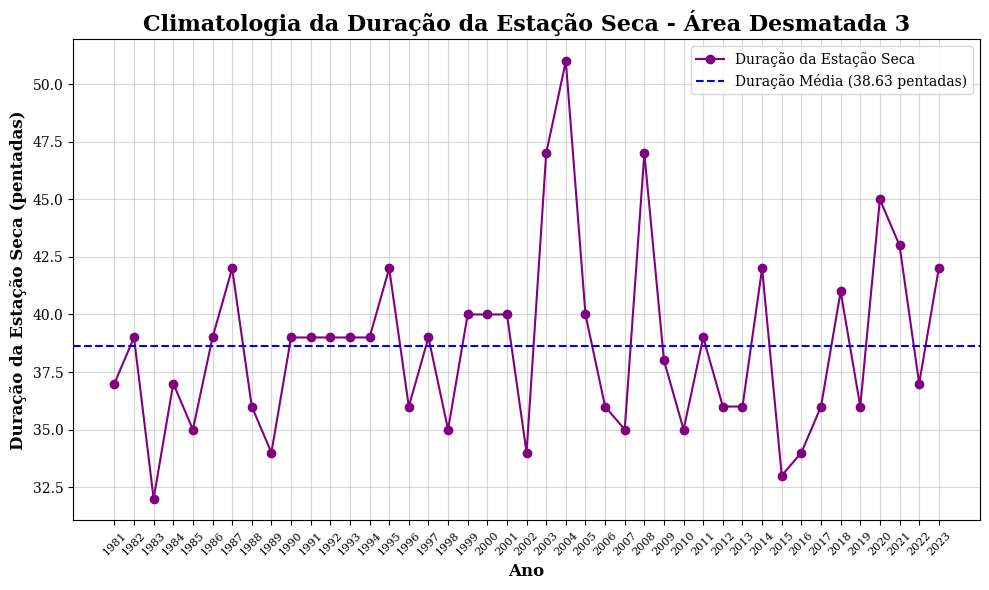

In [7]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico
def plot_dry_season_duration(season_df):
    # Cálculo da duração média
    mean_duration = season_df["Duração_Seca"].mean()

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(season_df["Ano"], season_df["Duração_Seca"], label="Duração da Estação Seca",  color='purple', marker='o')
    plt.axhline(mean_duration, color='blue', linestyle='--', label=f"Duração Média ({mean_duration:.2f} pentadas)")

    # Configurar título e rótulos
    plt.title("Climatologia da Duração da Estação Seca - Área Desmatada 3", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Duração da Estação Seca (pentadas)", fontsize=12, fontweight='bold')
    plt.xticks(season_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_dry_season_duration(season_df)


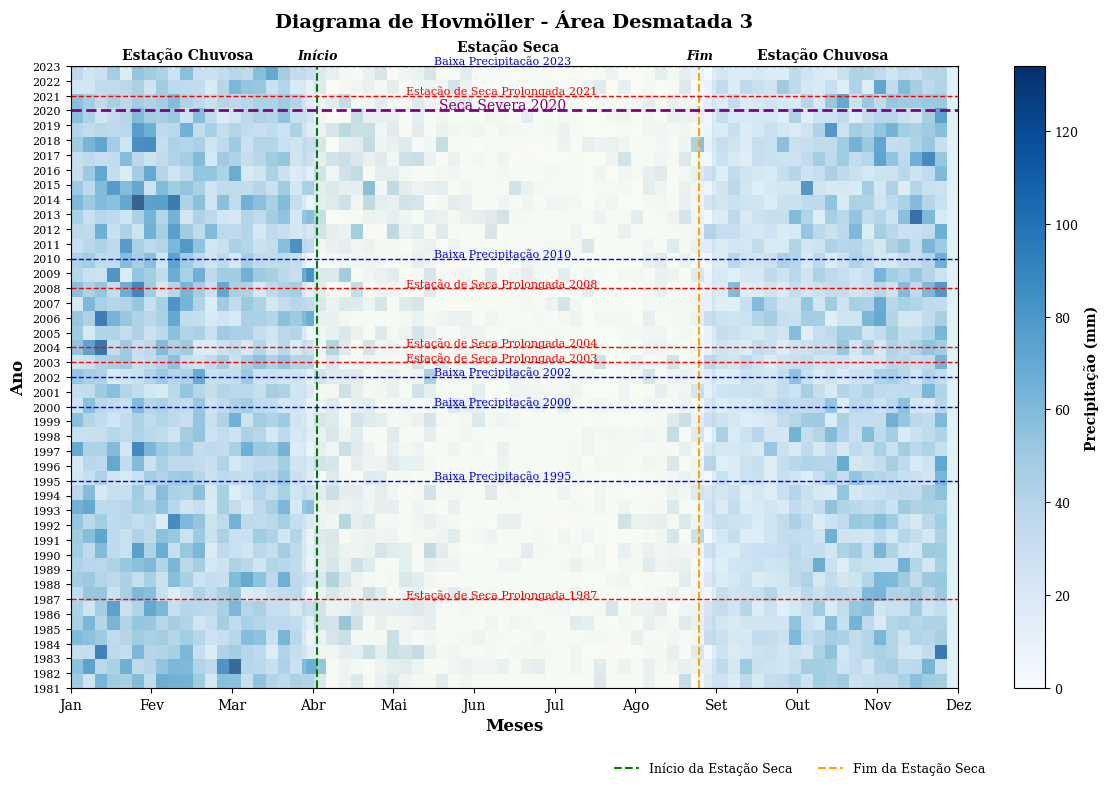


--- Análise de Regressão Linear ---
Equação da linha de tendência: Duração = 0.05 * Ano + -60.53
Inclinação (m): 0.05
Coeficiente de determinação (R²): 0.02


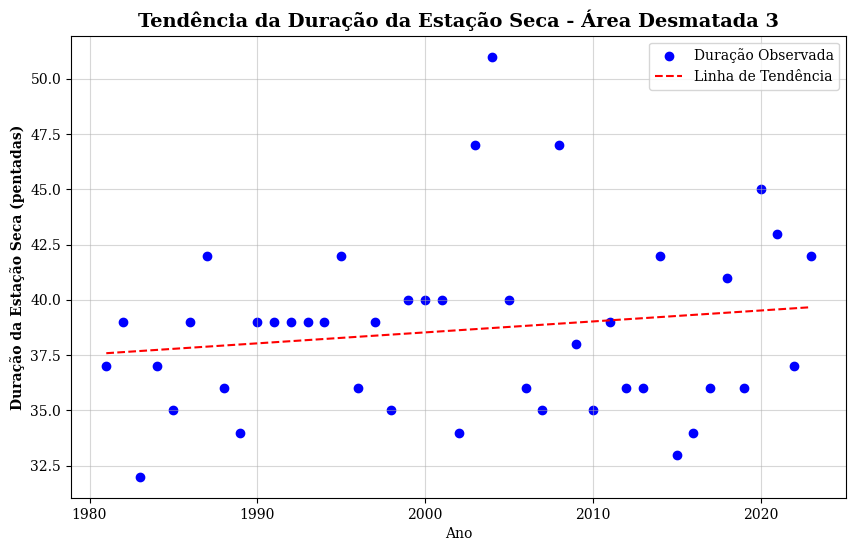

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Dados para análise
anos = season_df["Ano"]
duracao_seca = season_df["Duração_Seca"]

# Ajustar uma regressão linear (y = mx + b)
X = sm.add_constant(anos)  # Adiciona a constante (intercepto)
model = sm.OLS(duracao_seca, X).fit()  # Ajusta o modelo de regressão
trend_line = model.predict(X)  # Calcula a linha de tendência

# Coeficientes da regressão
coef_angular = model.params[1]  # Inclinação (m)
coef_intercepto = model.params[0]  # Intercepto (b)
r_squared = model.rsquared  # Coeficiente de determinação (qualidade do ajuste)

# Exibir resultados
print("\n--- Análise de Regressão Linear ---")
print(f"Equação da linha de tendência: Duração = {coef_angular:.2f} * Ano + {coef_intercepto:.2f}")
print(f"Inclinação (m): {coef_angular:.2f}")
print(f"Coeficiente de determinação (R²): {r_squared:.2f}")

# Criar um DataFrame com os resultados para exportação
resultados = pd.DataFrame({
    "Ano": anos,
    "Duração Observada": duracao_seca,
    "Linha de Tendência": trend_line
})

# Salvar os dados no Excel
resultados.to_excel("dados_analise_area_preservada3.xlsx", index=False)

# Plotar os dados e a linha de tendência
plt.figure(figsize=(10, 6))
plt.scatter(anos, duracao_seca, color='blue', label="Duração Observada")
plt.plot(anos, trend_line, color='red', linestyle='--', label="Linha de Tendência")
plt.title("Tendência da Duração da Estação Seca - Área Desmatada 3", fontweight='bold', fontsize=14)
plt.xlabel("Ano")
plt.ylabel("Duração da Estação Seca (pentadas)", fontweight='bold')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import statsmodels.api as sm

rcParams['font.family'] = 'serif'

# Carregar dados do Excel
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDematada3_precipitacao.xlsx'
df = pd.read_excel(amazonia)

# Transformar o DataFrame para formato longo (long format)
df_long = pd.melt(df, id_vars=["Pentada"], var_name="Ano", value_name="Precipitação")

# Remover linhas onde "Ano" não seja um número (exemplo: "Média")
df_long = df_long[pd.to_numeric(df_long["Ano"], errors="coerce").notna()]

# Converter a coluna "Ano" para numérico
df_long["Ano"] = pd.to_numeric(df_long["Ano"])

# Converter a coluna "Pentada" para numérico, removendo a palavra "º"
df_long["Pentada"] = df_long["Pentada"].str.replace("º", "").astype(int)

# Filtrar os dados de 1981 a 2023
df_filtered = df_long[(df_long["Ano"] >= 1981) & (df_long["Ano"] <= 2023)]

# Criar precipitation_df baseado nos dados filtrados
precipitation_df = df_filtered.groupby("Ano")["Precipitação"].sum().reset_index()
precipitation_df.rename(columns={"Precipitação": "Total_Precipitação"}, inplace=True)

# Função para análise de precipitação
def analyze_precipitation_data(precipitation_df):
    # Precipitação média anual
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()

    # Precipitação mínima e máxima
    min_precipitation = precipitation_df["Total_Precipitação"].min()
    max_precipitation = precipitation_df["Total_Precipitação"].max()

    # Ano com menor e maior precipitação
    min_year = precipitation_df.loc[precipitation_df["Total_Precipitação"].idxmin(), "Ano"]
    max_year = precipitation_df.loc[precipitation_df["Total_Precipitação"].idxmax(), "Ano"]

    # Aumento percentual da precipitação ao longo dos anos
    initial_precipitation = precipitation_df.iloc[0]["Total_Precipitação"]
    final_precipitation = precipitation_df.iloc[-1]["Total_Precipitação"]
    percentage_change = ((final_precipitation - initial_precipitation) / initial_precipitation) * 100

    # Exibir resultados no terminal
    print("\n--- Análise da Precipitação Anual Área Desmatada 3 ---")
    print(f"Precipitação Média Anual (mm): {mean_precipitation:.2f}")
    print(f"Precipitação Mínima Anual (mm): {min_precipitation} (Ano: {min_year})")
    print(f"Precipitação Máxima Anual (mm): {max_precipitation} (Ano: {max_year})")
    print(f"Aumento Percentual ao longo dos anos: {percentage_change:.2f}%\n")

    # Retornar os resultados
    return {
        "Precipitação Média Anual (mm)": mean_precipitation,
        "Precipitação Mínima Anual (mm)": min_precipitation,
        "Ano Mínimo": min_year,
        "Precipitação Máxima Anual (mm)": max_precipitation,
        "Ano Máximo": max_year,
        "Aumento Percentual (%)": percentage_change
    }

# Realizar a análise de precipitação
precipitation_analysis = analyze_precipitation_data(precipitation_df)

# Exibir o DataFrame de resultados
print(precipitation_analysis)


--- Análise da Precipitação Anual Área Desmatada 3 ---
Precipitação Média Anual (mm): 1705.52
Precipitação Mínima Anual (mm): 1368.5560860128364 (Ano: 1995)
Precipitação Máxima Anual (mm): 2228.8408935658426 (Ano: 2014)
Aumento Percentual ao longo dos anos: -27.26%

{'Precipitação Média Anual (mm)': 1705.5174785590063, 'Precipitação Mínima Anual (mm)': 1368.5560860128364, 'Ano Mínimo': 1995, 'Precipitação Máxima Anual (mm)': 2228.8408935658426, 'Ano Máximo': 2014, 'Aumento Percentual (%)': -27.261265637712185}


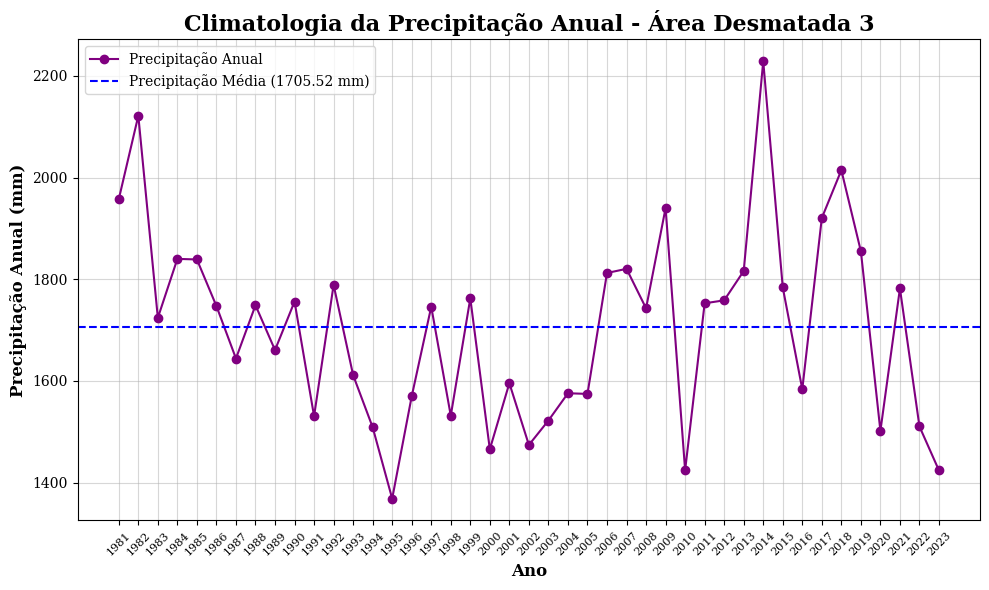

In [14]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico
def plot_precipitation_trend(precipitation_df):
    # Cálculo da precipitação média anual
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(precipitation_df["Ano"], precipitation_df["Total_Precipitação"], label="Precipitação Anual", color='purple', marker='o')
    plt.axhline(mean_precipitation, color='blue', linestyle='--', label=f"Precipitação Média ({mean_precipitation:.2f} mm)")

    # Configurar título e rótulos
    plt.title("Climatologia da Precipitação Anual - Área Desmatada 3", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold')
    plt.xticks(precipitation_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_precipitation_trend(precipitation_df)

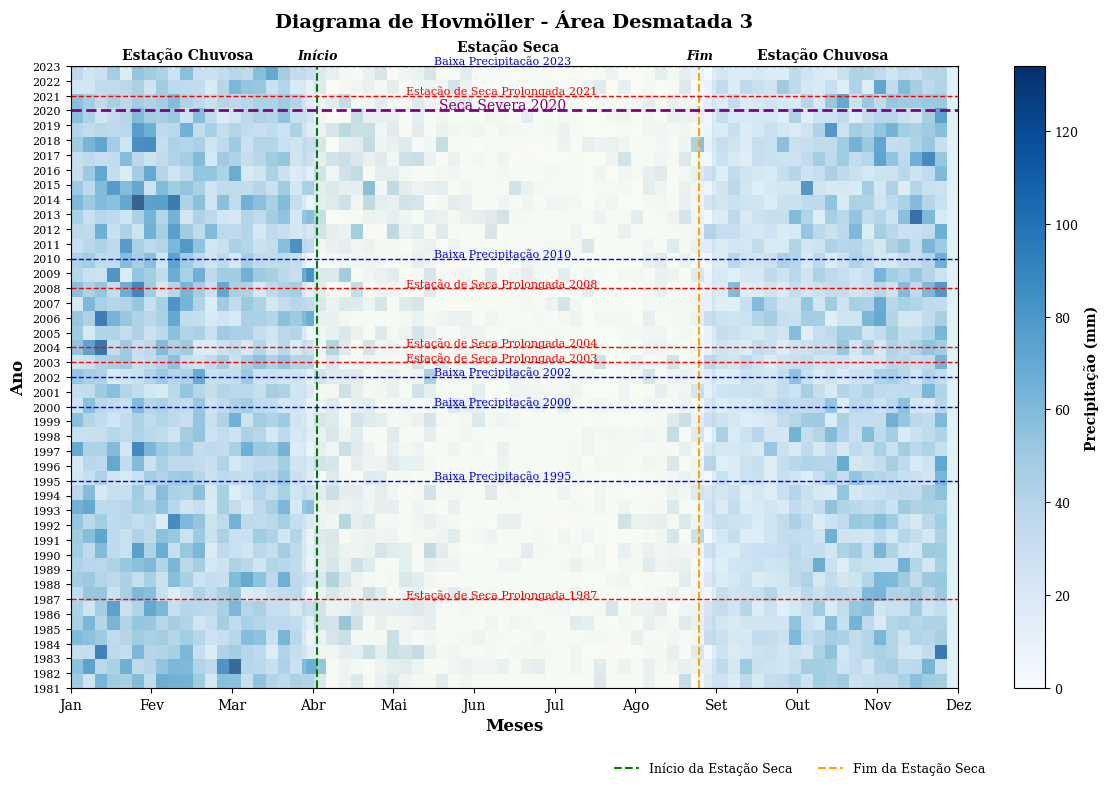

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Dados necessários (simulados)
anos = season_df["Ano"]
inicio_seca = season_df["Pentada_Início_Seca"]
fim_seca = season_df["Pentada_Fim_Seca"]

# Calcular a duração da estação seca
duracao_seca = fim_seca - inicio_seca

# Criar matriz para o diagrama de Hovmöller usando precipitação
hovmoller_matrix = np.zeros((len(anos), 73))  # 73 pentadas em um ano

# Preenchendo a matriz com dados de precipitação
for i, year in enumerate(anos):
    year_data = df_filtered[df_filtered["Ano"] == year]
    for pentada in year_data["Pentada"]:
        hovmoller_matrix[i, pentada - 1] = year_data.loc[year_data["Pentada"] == pentada, "Precipitação"].values[0]

# Identificar os anos com maior duração da estação seca
top_duracao_indices = duracao_seca.nlargest(6).index
seca_anos = anos[top_duracao_indices]
seca_pentadas = [35] * len(seca_anos)  # Exemplo: linha em pentada 35

# Identificar os anos com menor precipitação anual
precipitacao_ano = precipitation_df.groupby("Ano")["Total_Precipitação"].sum()
anos_menor_precipitacao = precipitacao_ano.nsmallest(6).index

# Configurações do gráfico
plt.figure(figsize=(12, 8))
plt.imshow(
    hovmoller_matrix,
    aspect="auto",
    cmap="Blues",  # Gradiente de azul
    origin="lower",
    extent=[1, 73, anos.min(), anos.max()],
)

# Adicionando áreas para estações seca e chuvosa
plt.axvspan(1, 20, color="lightblue", alpha=0.3)
plt.axvspan(21, 52, color="lightyellow", alpha=0.3)
plt.axvspan(53, 73, color="lightblue", alpha=0.3)

# Adicionar texto para identificar as estações
plt.text(10.5, anos.max() + 0.5, "Estação Chuvosa", fontsize=10, ha="center", fontweight="bold")
plt.text(36.5, anos.max() + 1, "Estação Seca", fontsize=10, ha="center", fontweight="bold")
plt.text(62, anos.max() + 0.5, "Estação Chuvosa", fontsize=10, ha="center", fontweight="bold")
plt.text(21, anos.max() + 0.5, "Início", fontsize=9, ha="center", fontweight="bold", style="italic")
plt.text(52, anos.max() + 0.5, "Fim", fontsize=9, ha="center", fontweight="bold", style="italic")

# Adicionar linhas verticais para início e fim da estação seca
plt.axvline(x=21, color="green", linestyle="--", linewidth=1.5, label="Início da Estação Seca")
plt.axvline(x=52, color="orange", linestyle="--", linewidth=1.5, label="Fim da Estação Seca")

# Barra de cores e rótulos
cbar = plt.colorbar(label="Precipitação (mm)")
cbar.set_label("Precipitação (mm)", fontsize=10, fontweight="bold")  # Eixo Y da barra em negrito
cbar.ax.tick_params(labelsize=9)

plt.title(
    "Diagrama de Hovmöller - Área Desmatada 3",
    fontsize=14,
    fontweight="bold",
    y=1.05
)
plt.xlabel("Meses", fontsize=12, fontweight="bold")
plt.ylabel("Ano", fontsize=12, fontweight="bold")  # Rotulo do eixo Y em negrito
plt.xticks(ticks=np.linspace(1, 73, num=12), labels=["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"], fontsize=10)
plt.yticks(ticks=anos, labels=anos, fontsize=8)

# Marcar os anos com menor precipitação anual
for ano in anos_menor_precipitacao:
    if ano == 2020:
        # Para o ano de 2020, usar "Seca Severa" com linha roxa e fonte roxa
        plt.axhline(y=ano, color="purple", linestyle="--", linewidth=2)  # Linha roxa e mais grossa
        plt.text(
            36,  # Ajuste a posição em x conforme necessário
            ano + 0.1,
            "Seca Severa 2020",  # Apenas "Seca Severa" para 2020
            color="purple",  # Fonte roxa
            fontsize=10,  # Fonte maior
            ha="center"
        )
        # Continuar para evitar duplicação
        continue

    # Para os outros anos, usar "Baixa Precipitação" e linha azul
    plt.axhline(y=ano, color="blue", linestyle="--", linewidth=1)
    plt.text(
        36,  # Ajuste a posição em x conforme necessário
        ano + 0.1,
        f"Baixa Precipitação {ano}",  # Exibe o ano normalmente
        color="blue",
        fontsize=8,
        ha="center"
    )

# Anos com duração da estação seca muito acima do normal
anos_seca_prolongada = [2021, 2008, 2004, 2003, 1987]

for ano in anos_seca_prolongada:
    # Adicionar linha tracejada vermelha
    plt.axhline(y=ano, color="red", linestyle="--", linewidth=1)
    
    # Adicionar texto explicativo com o ano
    plt.text(
        36,  # Posição x central
        ano + 0.1,  # Ajuste em y para ficar logo acima da linha
        f"Estação de Seca Prolongada {ano}",  # Texto com o ano
        color="red",  # Cor do texto
        fontsize=8,  # Tamanho do texto
        ha="center"  # Alinhamento horizontal
    )

# Adicionar legenda para as linhas de início e fim da estação seca (fora do gráfico)
plt.legend(
    loc="upper left",  # Localização da legenda (no topo)
    bbox_to_anchor=(0.6, -0.1),  # Posiciona fora do gráfico
    fontsize=9,  # Tamanho da fonte
    frameon=False,  # Remove a borda da legenda
    ncol=2  # Coloca a legenda em duas colunas, se necessário
)

# Ajustar layout e mostrar
plt.tight_layout()
plt.show()


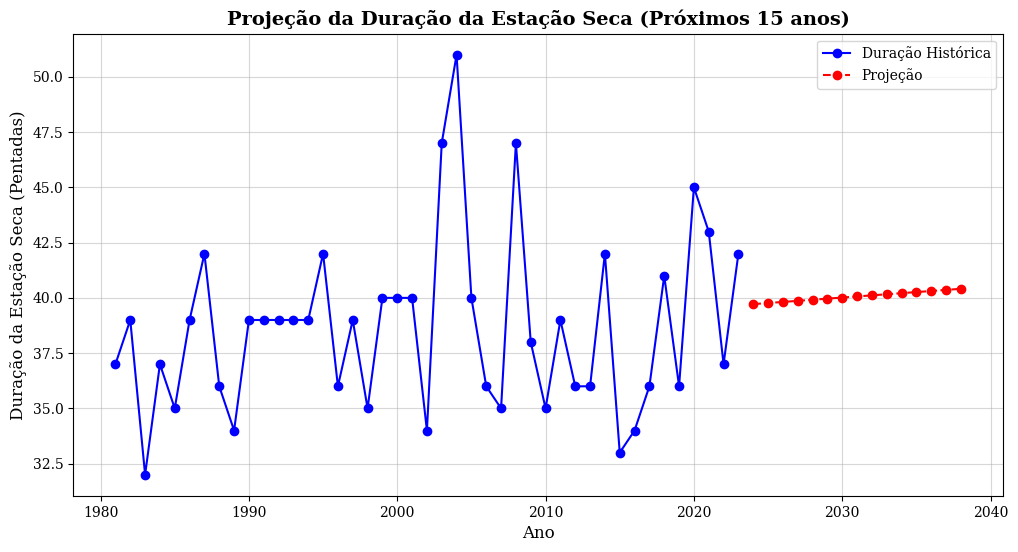

     Ano  Duração_Seca_Projetada
0   2024               39.717608
1   2025               39.767140
2   2026               39.816672
3   2027               39.866204
4   2028               39.915735
5   2029               39.965267
6   2030               40.014799
7   2031               40.064331
8   2032               40.113863
9   2033               40.163395
10  2034               40.212927
11  2035               40.262458
12  2036               40.311990
13  2037               40.361522
14  2038               40.411054


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import rcParams

# Configuração de fonte para o gráfico
rcParams['font.family'] = 'serif'

# Carregar os dados históricos
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDematada3_precipitacao.xlsx'
df = pd.read_excel(amazonia)

# Dados sobre duração da estação seca já calculados previamente
# Assumindo que você já gerou o DataFrame season_df com as colunas ["Ano", "Duração_Seca"]

# Separar os dados de entrada (Ano) e saída (Duração_Seca)
X = season_df["Ano"].values.reshape(-1, 1)  # Transformar em matriz para o modelo
y = season_df["Duração_Seca"].values

# Criar e ajustar o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Gerar projeções para os próximos 15 anos (2024 a 2038)
anos_futuros = np.arange(2024, 2039).reshape(-1, 1)  # Anos de 2024 a 2038
projecoes = modelo.predict(anos_futuros)

# Combinar anos futuros e projeções em um DataFrame
projecao_df = pd.DataFrame({
    "Ano": anos_futuros.flatten(),
    "Duração_Seca_Projetada": projecoes
})

# Plotar a duração da estação seca (histórico + projeções)
plt.figure(figsize=(12, 6))

# Dados históricos
plt.plot(season_df["Ano"], season_df["Duração_Seca"], marker="o", label="Duração Histórica", color="blue")

# Projeções
plt.plot(projecao_df["Ano"], projecao_df["Duração_Seca_Projetada"], marker="o", linestyle="--", label="Projeção", color="red")

# Configurações do gráfico
plt.title("Projeção da Duração da Estação Seca (Próximos 15 anos)", fontweight="bold", fontsize=14)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Duração da Estação Seca (Pentadas)", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

# Salvar o gráfico
output_path_projection = "/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Resultados/Projecao_Duracao_Estacao_Seca.pdf"
plt.savefig(output_path_projection, format="pdf")

# Exibir o gráfico
plt.show()

# Exibir projeções
print(projecao_df)

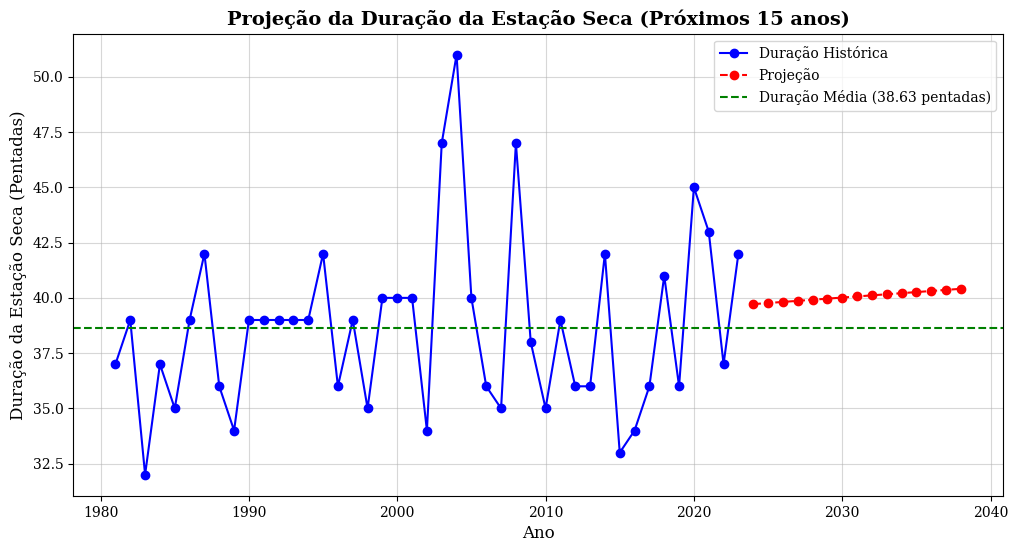

     Ano  Duração_Seca_Projetada
0   2024               39.717608
1   2025               39.767140
2   2026               39.816672
3   2027               39.866204
4   2028               39.915735
5   2029               39.965267
6   2030               40.014799
7   2031               40.064331
8   2032               40.113863
9   2033               40.163395
10  2034               40.212927
11  2035               40.262458
12  2036               40.311990
13  2037               40.361522
14  2038               40.411054


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import rcParams

# Configuração de fonte para o gráfico
rcParams['font.family'] = 'serif'

# Dados sobre duração da estação seca já calculados previamente
# Assumindo que você já gerou o DataFrame `season_df` com as colunas ["Ano", "Duração_Seca"]

# Calcular a média da duração histórica da estação seca
mean_duration = season_df["Duração_Seca"].mean()

# Separar os dados de entrada (Ano) e saída (Duração_Seca)
X = season_df["Ano"].values.reshape(-1, 1)  # Transformar em matriz para o modelo
y = season_df["Duração_Seca"].values

# Criar e ajustar o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Gerar projeções para os próximos 15 anos (2024 a 2038)
anos_futuros = np.arange(2024, 2039).reshape(-1, 1)  # Anos de 2024 a 2038
projecoes = modelo.predict(anos_futuros)

# Combinar anos futuros e projeções em um DataFrame
projecao_df = pd.DataFrame({
    "Ano": anos_futuros.flatten(),
    "Duração_Seca_Projetada": projecoes
})

# Plotar a duração da estação seca (histórico + projeções)
plt.figure(figsize=(12, 6))

# Dados históricos
plt.plot(season_df["Ano"], season_df["Duração_Seca"], marker="o", label="Duração Histórica", color="blue")

# Projeções
plt.plot(projecao_df["Ano"], projecao_df["Duração_Seca_Projetada"], marker="o", linestyle="--", label="Projeção", color="red")

# Linha horizontal para a média histórica
plt.axhline(mean_duration, color='green', linestyle='--', label=f"Duração Média ({mean_duration:.2f} pentadas)")

# Configurações do gráfico
plt.title("Projeção da Duração da Estação Seca (Próximos 15 anos)", fontweight="bold", fontsize=14)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Duração da Estação Seca (Pentadas)", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

# Salvar o gráfico
output_path_projection = "/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Resultados/Projecao_Duracao_Estacao_Seca.pdf"
plt.savefig(output_path_projection, format="pdf")

# Exibir o gráfico
plt.show()

# Exibir projeções
print(projecao_df)


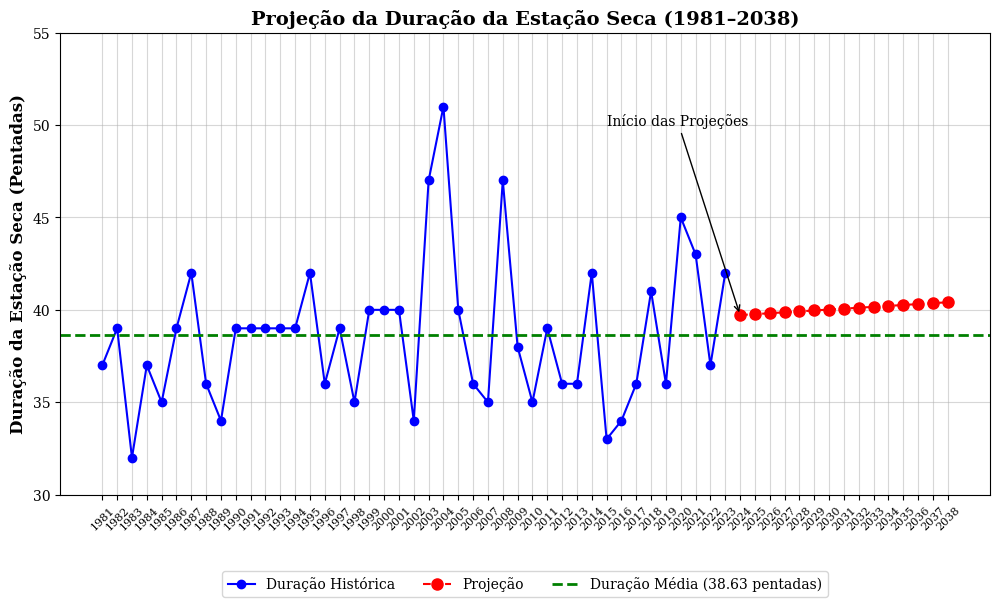

In [20]:
import matplotlib.pyplot as plt

# Ajustar os dados do gráfico para refinar a estética
plt.figure(figsize=(12, 6))

# Dados históricos
plt.plot(season_df["Ano"], season_df["Duração_Seca"], marker="o", label="Duração Histórica", color="blue")

# Projeções
plt.plot(projecao_df["Ano"], projecao_df["Duração_Seca_Projetada"], marker="o", markersize=8, linestyle="--", label="Projeção", color="red")

# Linha horizontal para a média histórica
plt.axhline(mean_duration, color='green', linestyle='--', linewidth=2, label=f"Duração Média ({mean_duration:.2f} pentadas)")

# Ajustar o eixo X para mostrar todos os anos
plt.xticks(ticks=season_df["Ano"].tolist() + projecao_df["Ano"].tolist(), rotation=45, fontsize=8)

# Ajuste de escala do eixo Y
plt.ylim(30, 55)

# Configurações do gráfico
plt.title("Projeção da Duração da Estação Seca (1981–2038)", fontweight="bold", fontsize=14)
plt.ylabel("Duração da Estação Seca (Pentadas)", fontsize=12, fontweight="bold")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(alpha=0.5)

# Anotação para destacar início das projeções
plt.annotate("Início das Projeções", xy=(2024, projecoes[0]), xytext=(2015, 50),
             arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=10)

# Salvar e exibir o gráfico
plt.savefig(output_path_projection, format="pdf")
plt.show()


Valores projetados da duração da estação seca:
Ano: 2024, Duração projetada: 39.72 pentadas
Ano: 2025, Duração projetada: 39.77 pentadas
Ano: 2026, Duração projetada: 39.82 pentadas
Ano: 2027, Duração projetada: 39.87 pentadas
Ano: 2028, Duração projetada: 39.92 pentadas
Ano: 2029, Duração projetada: 39.97 pentadas
Ano: 2030, Duração projetada: 40.01 pentadas
Ano: 2031, Duração projetada: 40.06 pentadas
Ano: 2032, Duração projetada: 40.11 pentadas
Ano: 2033, Duração projetada: 40.16 pentadas
Ano: 2034, Duração projetada: 40.21 pentadas
Ano: 2035, Duração projetada: 40.26 pentadas
Ano: 2036, Duração projetada: 40.31 pentadas
Ano: 2037, Duração projetada: 40.36 pentadas
Ano: 2038, Duração projetada: 40.41 pentadas


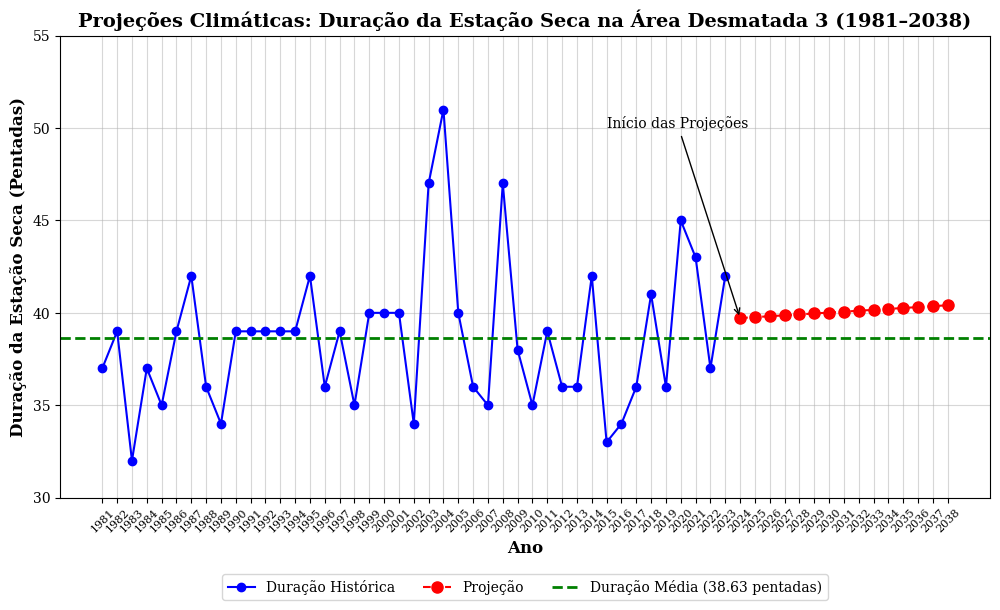

In [21]:
# Imprimir os valores da projeção
print("Valores projetados da duração da estação seca:")
for ano, duracao in zip(projecao_df["Ano"], projecao_df["Duração_Seca_Projetada"]):
    print(f"Ano: {ano}, Duração projetada: {duracao:.2f} pentadas")

# Ajustar os dados do gráfico para refinar a estética
plt.figure(figsize=(12, 6))

# Dados históricos
plt.plot(season_df["Ano"], season_df["Duração_Seca"], marker="o", label="Duração Histórica", color="blue")

# Projeções
plt.plot(projecao_df["Ano"], projecao_df["Duração_Seca_Projetada"], marker="o", markersize=8, linestyle="--", label="Projeção", color="red")

# Linha horizontal para a média histórica
plt.axhline(mean_duration, color='green', linestyle='--', linewidth=2, label=f"Duração Média ({mean_duration:.2f} pentadas)")

# Ajustar o eixo X para mostrar todos os anos
plt.xticks(ticks=season_df["Ano"].tolist() + projecao_df["Ano"].tolist(), rotation=45, fontsize=8)

# Ajuste de escala do eixo Y
plt.ylim(30, 55)

# Configurações do gráfico
plt.title("Projeções Climáticas: Duração da Estação Seca na Área Desmatada 3 (1981–2038)", fontweight="bold", fontsize=14)
plt.xlabel("Ano", fontsize=12, fontweight="bold")
plt.ylabel("Duração da Estação Seca (Pentadas)", fontsize=12, fontweight="bold")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(alpha=0.5)

# Anotação para destacar início das projeções
plt.annotate("Início das Projeções", xy=(2024, projecoes[0]), xytext=(2015, 50),
             arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=10)

# Salvar e exibir o gráfico
plt.savefig(output_path_projection, format="pdf")
plt.show()



--- Precipitação Média Anual ---
Ano
1981    1957.553905
1982    2121.601547
1983    1724.101222
1984    1840.066420
1985    1838.933639
1986    1747.283740
1987    1644.129418
1988    1748.900139
1989    1660.736213
1990    1756.108365
1991    1530.632626
1992    1788.967370
1993    1611.377411
1994    1508.903648
1995    1368.556086
1996    1569.729953
1997    1745.973116
1998    1531.641879
1999    1762.482062
2000    1465.664779
2001    1595.596033
2002    1474.115579
2003    1522.130427
2004    1575.798247
2005    1574.527933
2006    1812.341592
2007    1820.486480
2008    1742.835871
2009    1940.036460
2010    1424.191991
2011    1752.712676
2012    1758.536669
2013    1816.177420
2014    2228.840894
2015    1783.952204
2016    1583.624788
2017    1920.435760
2018    2014.553247
2019    1855.054152
2020    1501.714495
2021    1781.900986
2022    1510.444202
2023    1423.899935
Name: Total_Precipitação, dtype: float64


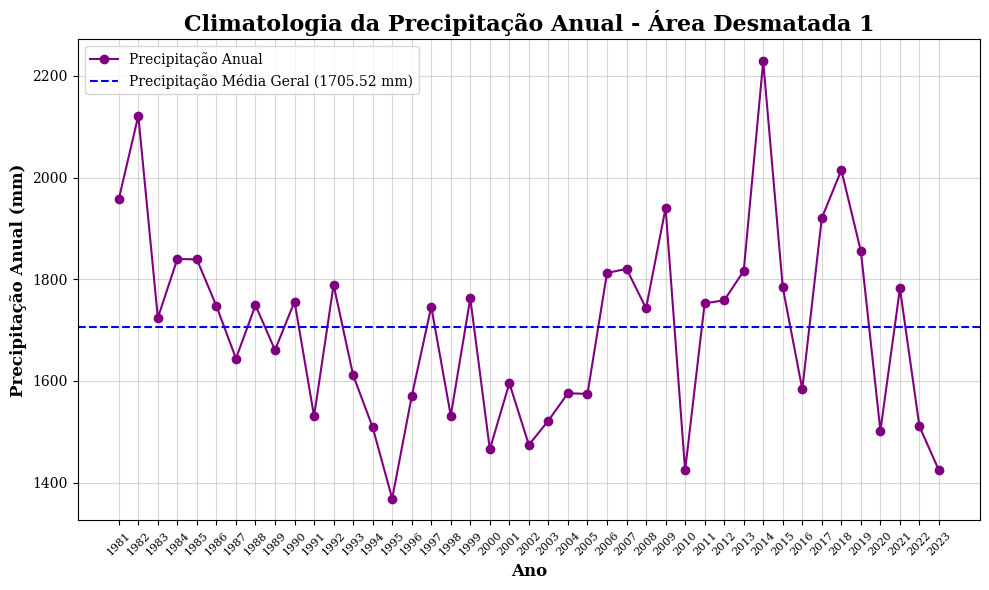

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico e calcular a precipitação média anual
def plot_precipitation_trend(precipitation_df):
    # Cálculo da precipitação média anual por ano
    yearly_mean_precipitation = precipitation_df.groupby("Ano")["Total_Precipitação"].mean()

    # Exibir a precipitação média anual no terminal
    print("\n--- Precipitação Média Anual ---")
    print(yearly_mean_precipitation)

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(precipitation_df["Ano"], precipitation_df["Total_Precipitação"], label="Precipitação Anual", color='purple', marker='o')
    plt.axhline(precipitation_df["Total_Precipitação"].mean(), color='blue', linestyle='--', label=f"Precipitação Média Geral ({precipitation_df['Total_Precipitação'].mean():.2f} mm)")

    # Configurar título e rótulos
    plt.title("Climatologia da Precipitação Anual - Área Desmatada 1", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold')
    plt.xticks(precipitation_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

    # Retornar os valores de precipitação média anual
    return yearly_mean_precipitation

# Chamar a função e exibir os resultados
yearly_mean = plot_precipitation_trend(precipitation_df)

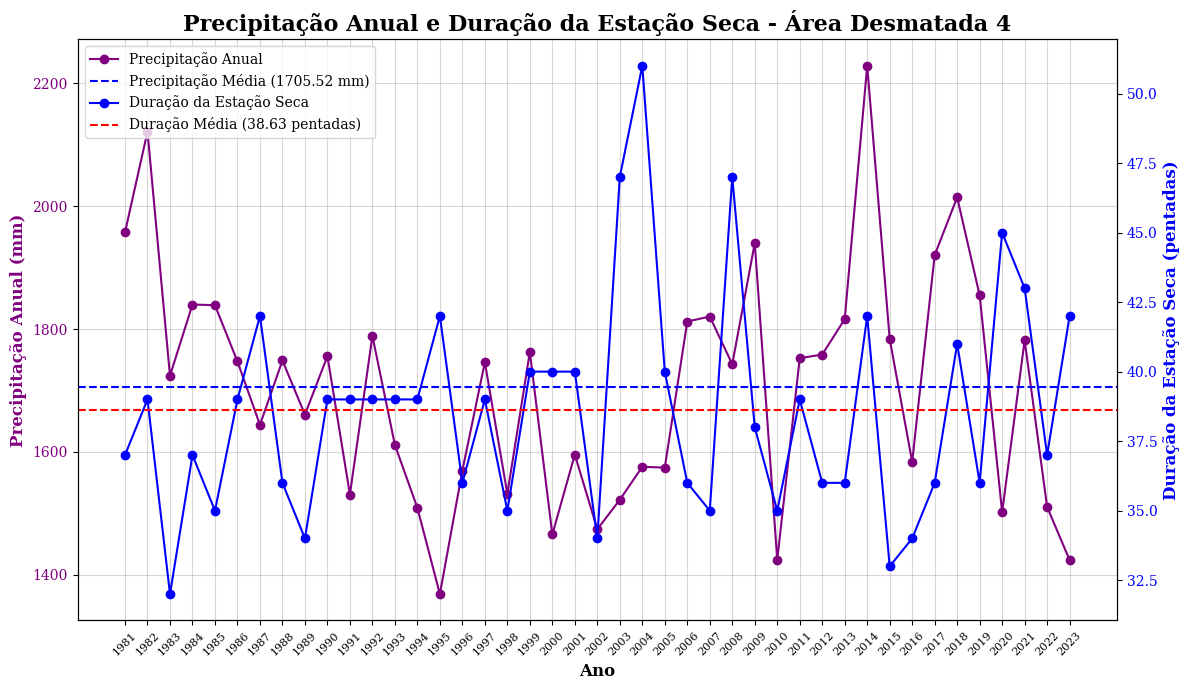

In [ ]:
import matplotlib.pyplot as plt

# Função para combinar os gráficos de precipitação e duração da estação seca
def plot_combined_trend(precipitation_df, season_df):
    # Criar a figura e os eixos
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Gráfico da precipitação (eixo esquerdo)
    ax1.plot(
        precipitation_df["Ano"], precipitation_df["Total_Precipitação"], 
        label="Precipitação Anual", color='purple', marker='o'
    )
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()
    ax1.axhline(mean_precipitation, color='blue', linestyle='--', label=f"Precipitação Média ({mean_precipitation:.2f} mm)")
    ax1.set_xlabel("Ano", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')
    ax1.grid(alpha=0.5)

    # Gráfico da duração da estação seca (eixo direito)
    ax2 = ax1.twinx()
    ax2.plot(
        season_df["Ano"], season_df["Duração_Seca"], 
        label="Duração da Estação Seca", color='blue', marker='o'
    )
    mean_duration = season_df["Duração_Seca"].mean()
    ax2.axhline(mean_duration, color='red', linestyle='--', label=f"Duração Média ({mean_duration:.2f} pentadas)")
    ax2.set_ylabel("Duração da Estação Seca (pentadas)", fontsize=12, fontweight='bold', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Configurar ticks do eixo x para mostrar todos os anos
    all_years = sorted(precipitation_df["Ano"].unique())  # Listar todos os anos únicos
    ax1.set_xticks(all_years)  # Definir os anos como ticks no eixo x
    ax1.set_xticklabels(all_years, rotation=45, fontsize=8)  # Rotacionar os anos para melhor legibilidade

    # Combinar legendas dos dois eixos
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=10)

    # Título do gráfico
    plt.title("Precipitação Anual e Duração da Estação Seca - Área Desmatada 4", fontsize=16, fontweight='bold')

    # Ajustar layout
    plt.tight_layout()

    # Mostrar o gráfico
    plt.show()

# Chamar a função para plotar os gráficos combinados
plot_combined_trend(precipitation_df, season_df)